In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
import string
import re

from sklearn.feature_extraction.text import CountVectorizer

import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import joblib

from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [2]:
# discharge prediction data

train_data = pd.read_csv("./data/discharge/train.csv", index_col = 0)
val_data = pd.read_csv("./data/discharge/val.csv",index_col = 0)
test_data = pd.read_csv("./data/discharge/test.csv",index_col = 0)

print(f"Training data shape: {train_data.shape}")
print(f"val data shape: {val_data.shape}")
print(f"test data shape: {test_data.shape}")

Training data shape: (26245, 3)
val data shape: (3037, 3)
test data shape: (3063, 3)


In [8]:
train_data.head()

,ID,TEXT,Label
0,159214.0,lv cavity size. normal regional lv systolic fu...,1.0
1,167234.0,"to 80%, but then would come back into the high...",0.0
2,183362.0,laboratories on admission were a white count 1...,1.0
3,194853.0,"4 mg tablet, sublingual sig: one (1) tablet su...",1.0
4,196855.0,your inr between . 14) we started you on a hep...,1.0


In [47]:
# convert label floats to int
train_data.Label = train_data.Label



TypeError: cannot convert the series to <class 'int'>

In [48]:
# split into training and test sets

X_train = train_data.TEXT
y_train = train_data.Label.astype(int)

X_valid = val_data.TEXT
y_valid = val_data.Label.astype(int)

X_test = test_data.TEXT
y_test = test_data.Label.astype(int)

In [49]:
y_test

290       1
291       1
292       1
293       1
455       1
456       1
457       1
458       1
459       1
460       1
461       1
462       1
463       1
464       1
465       1
475       1
476       1
477       1
478       1
479       1
480       1
481       1
494       1
495       1
496       1
497       1
498       1
499       1
512       1
513       1
         ..
213645    1
213646    1
213647    1
214505    0
214506    0
214507    0
214508    0
214509    0
214510    0
214511    0
214512    0
214513    0
214514    0
214515    0
214516    0
214517    0
214882    1
214883    1
214884    1
214885    1
214886    1
215639    0
216568    1
216569    1
216570    1
216571    1
216910    1
216911    1
216912    1
216913    1
Name: Label, Length: 3063, dtype: int32

In [14]:
# build tokenize function

def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [4]:
# convert text to vectors

#give some stop words

my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']



In [9]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = None, stop_words =my_new_stop_words)
#
# This could take a while
vect.fit(train_data.TEXT.values)

X_train_tf = vect.transform(X_train.values)
X_valid_tf = vect.transform(X_valid.values)

print(X_train_tf.shape)
print(X_valid_tf.shape)
# print(y_train.shape)
# print(y_valid.shape)

(26245, 3000)
(3037, 3000)


In [6]:
# do same to test

X_test_tf = vect.transform(X_train.values)

# Zipfs' law

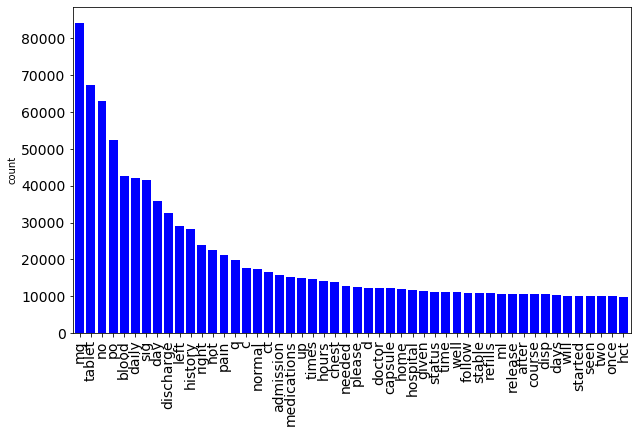

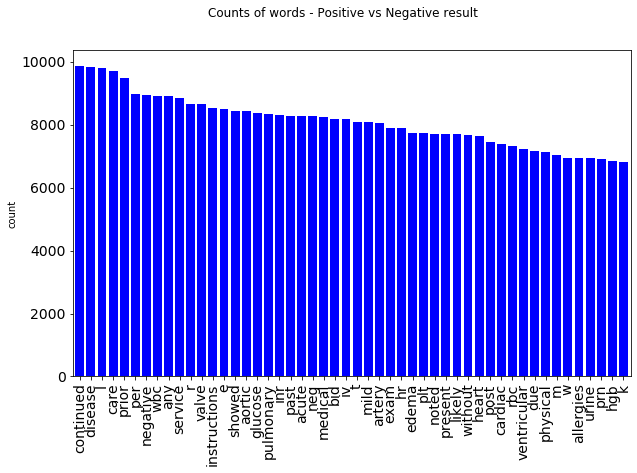

In [17]:
neg_doc_matrix = vect.transform(train_data[train_data.Label == 0].TEXT)
pos_doc_matrix = vect.transform(train_data[train_data.Label == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.suptitle('Counts of words - Positive vs Negative result')
plt.savefig('./results/plots/Counts_of_words.png')
plt.show()

Train AUC:0.669
Valid AUC:0.653
Train accuracy:0.623
Valid accuracy:0.615
Train recall:0.635
Valid recall:0.617
Train precision:0.620
Valid precision:0.643
Train specificity:0.610
Valid specificity:0.612
Train prevalence:0.500
Valid prevalence:0.531


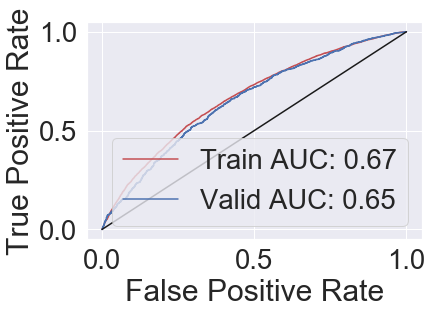

In [25]:
# simple lr

clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)


model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]


def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)



from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# build some models

In [11]:
from tqdm import tqdm
def run_exps(X_train , y_train, X_test, y_test):
    '''
        Lightweight script to test many models and find winners
    :param X_train: training split
        :param y_train: training target vector
        :param X_test: test split
        :param y_test: test target vector
        :return: DataFrame of predictions
        '''

    dfs = []
#     models = [('LogReg', LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)), 
#               ('RF', RandomForestClassifier()),
#               ('KNN', KNeighborsClassifier()),
#               ('SVM', SVC()), 
#               ('GNB', GaussianNB()),
#               ('XGB', XGBClassifier())]

    models = [('LogReg', LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)), 
              ('RF', RandomForestClassifier()),
              ('KNN', KNeighborsClassifier()),             
              ('XGB', XGBClassifier())]
               
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['not-readmitted', 'admitted']
    for name, model in tqdm(models):
        print(f"working on {name}")       
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [15]:
final = run_exps(X_train_tf, y_train, X_valid_tf, y_valid)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

working on LogReg


 25%|█████████████████████                                                               | 1/4 [00:02<00:06,  2.24s/it]

LogReg
                precision    recall  f1-score   support

not-readmitted       0.59      0.61      0.60      1424
      admitted       0.64      0.62      0.63      1613

      accuracy                           0.61      3037
     macro avg       0.61      0.61      0.61      3037
  weighted avg       0.62      0.61      0.62      3037

working on RF


 50%|█████████████████████████████████████████▌                                         | 2/4 [07:09<04:19, 129.77s/it]

RF
                precision    recall  f1-score   support

not-readmitted       0.59      0.60      0.59      1424
      admitted       0.64      0.62      0.63      1613

      accuracy                           0.61      3037
     macro avg       0.61      0.61      0.61      3037
  weighted avg       0.61      0.61      0.61      3037

working on KNN


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [08:40<01:58, 118.17s/it]

KNN
                precision    recall  f1-score   support

not-readmitted       0.50      0.63      0.56      1424
      admitted       0.58      0.45      0.51      1613

      accuracy                           0.54      3037
     macro avg       0.54      0.54      0.53      3037
  weighted avg       0.55      0.54      0.53      3037

working on XGB
[13:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ntaylor\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ntaylor\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ntaylor\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ntaylor\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ntaylor\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ntaylor\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [09:00<00:00, 135.11s/it]

XGB
                precision    recall  f1-score   support

not-readmitted       0.57      0.64      0.61      1424
      admitted       0.65      0.57      0.61      1613

      accuracy                           0.61      3037
     macro avg       0.61      0.61      0.61      3037
  weighted avg       0.61      0.61      0.61      3037



In [16]:
final

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.365075,0.017900,0.611926,0.611948,0.611926,0.611916,0.648868,LogReg
1,0.358075,0.016960,0.610592,0.610966,0.610592,0.610393,0.654793,LogReg
2,0.343103,0.017953,0.599352,0.599607,0.599352,0.599299,0.641737,LogReg
3,0.361017,0.016952,0.596495,0.596519,0.596495,0.596505,0.636703,LogReg
4,0.322105,0.017008,0.607163,0.607178,0.607163,0.607080,0.650000,LogReg
5,65.364344,0.460771,0.614974,0.615002,0.614974,0.614961,0.659234,RF
6,65.651941,0.486680,0.618213,0.618392,0.618213,0.618144,0.659806,RF
7,66.299790,0.459783,0.606592,0.606906,0.606592,0.606515,0.647801,RF
8,64.908502,0.471738,0.610402,0.610487,0.610402,0.610423,0.657778,RF
9,65.689992,0.457777,0.613831,0.613839,0.613831,0.613833,0.658991,RF


In [17]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

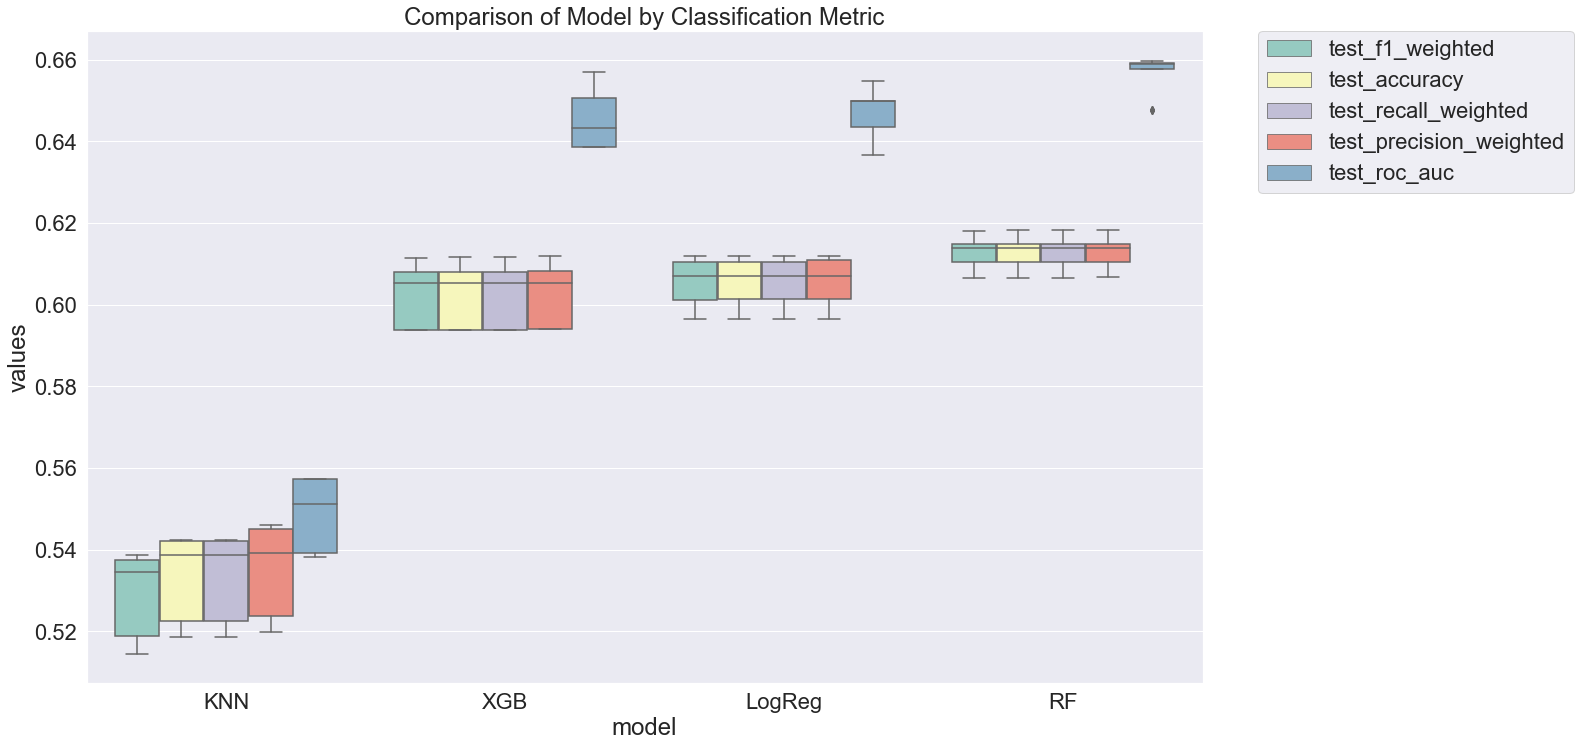

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./results/plots/cls_benchmark_models_performance.png',dpi=300)

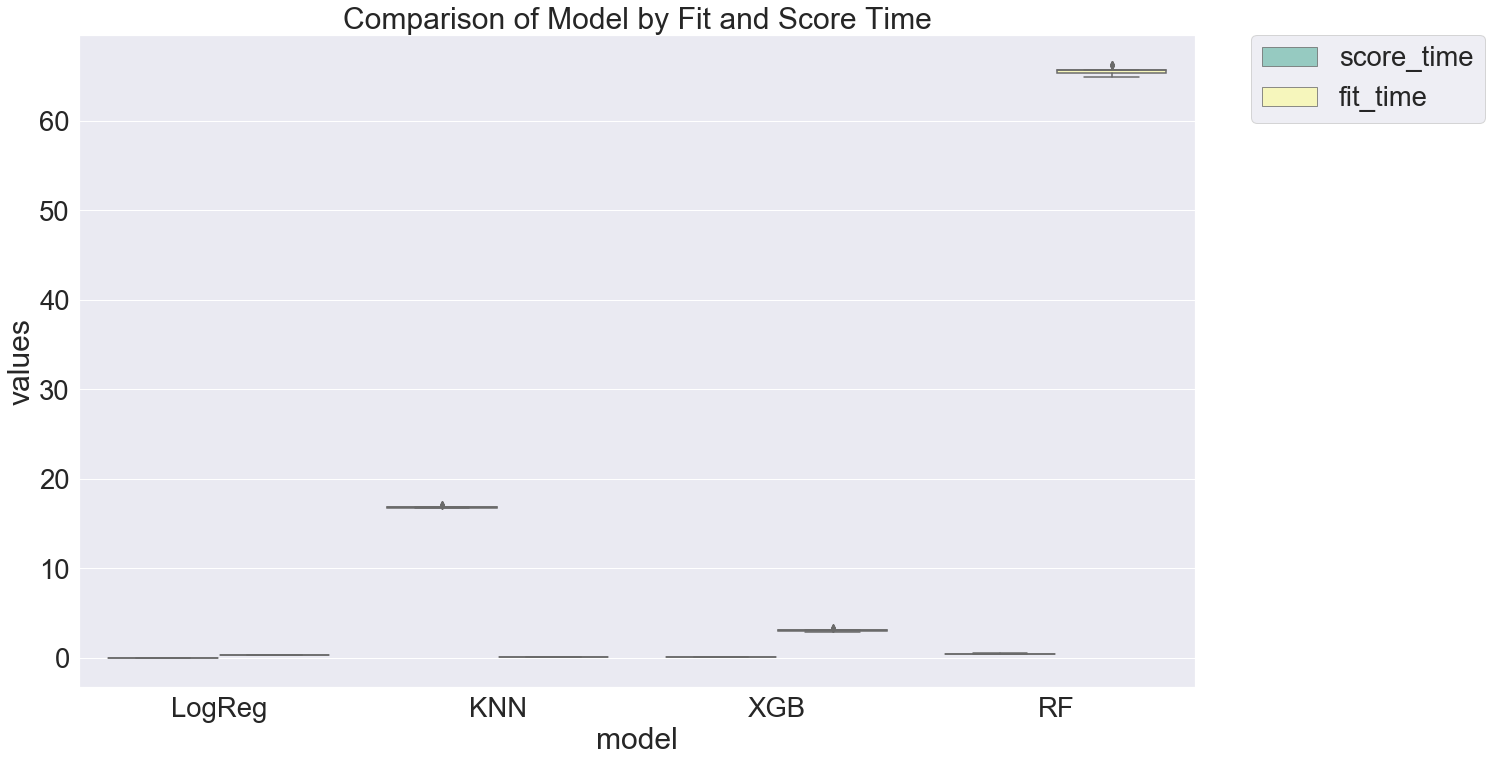

In [19]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./results/plots/cls_benchmark_models_time.png',dpi=300)

Train AUC:1.000
Valid AUC:0.656
Train accuracy:1.000
Valid accuracy:0.594
Train recall:1.000
Valid recall:0.622
Train precision:1.000
Valid precision:0.639
Train specificity:1.000
Valid specificity:0.562
Train prevalence:0.500
Valid prevalence:0.531


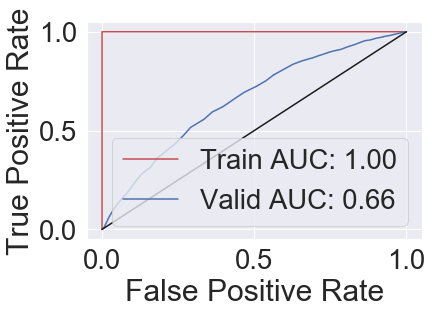

In [24]:
clf=RandomForestClassifier()
clf.fit(X_train_tf, y_train)


model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]


def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)



from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))

plt.figure(figsize=(20, 12))
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# save
# joblib.dump(clf_final, ".model/random_forest.joblib")

In [27]:
clf_final = clf
# save
joblib.dump(clf_final, "./model/random_forest.joblib")

['./model/random_forest.joblib']

# Explaining predictions using LIME

In [41]:
from lime import lime_text
from sklearn.pipeline import make_pipeline

#use vectorizer trained earlier
vectorizer = vect
c = make_pipeline(vectorizer, clf_final)

In [44]:
from lime.lime_text import LimeTextExplainer
class_names=["not readmitted", "readmitted"]
explainer = LimeTextExplainer(class_names=class_names)

In [33]:
X_test.iloc[83]

'tablet po bid (2 times a day). disp:*60 tablet(s)* refills:*2* ferrous sulfate 325 (65) mg tablet sig: one (1) tablet po bid (2 times a day). disp:*60 tablet(s)* refills:*2* cefpodoxime 200 mg tablet sig: one (1) tablet po q12h (every 12 hours). disp:*100 tablet(s)* refills:*0* metronidazole 500 mg tablet sig: one (1) tablet po tid (3 times a day). disp:*90 tablet(s)* refills:*1* discharge disposition: home with service facility: discharge diagnosis: primary diagnoses: e coli urinary tract infection bacteremia decubitus ulcers pelvic osteo secondary diagnoses: t12 paraplegia acute on chronic renal insufficiency seizure disorder discharge condition: good discharge instructions: you are discharged to home and will continue all medications as prescribed. please contact your or present to the er if you experience fevers, chills, night sweats, altered mental status or other concerns.please continue taking antibiotics by mouth unless recommended otherwise by infectious disease specialists. 

In [36]:
y_test.iloc[83]

0.0

In [53]:
idx = 85
exp = explainer.explain_instance(X_test.iloc[idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Document text: ', X_test.iloc[idx])
print('Probability(christian) =', c.predict_proba([X_test.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_test.iloc[idx]])

Document id: 85
Document text:  some bilateral opacifications in the left upper and right upper lobes with multifocal pneumonia. ekg showed atrial fibrillation at 120, with poor r-wave progression with left axis deviation, pseudochanges in t waves in v1 through v3, compared to 6/. hospital course: # pulmonary: the patient was subsequently placed on bipap overnight, while in the micu. the oxygenation status improved significantly overnight. she was subsequently able to tolerate saturation well. on 5 liters nasal cannula saturating 95%. she was subsequently called out of the unit and she was continued on albuterol and atrovent inhalers. chest ct and supplemental oxygen as well as mucomyst. she was started on levofloxacin for presumed pneumonia and sputum cultures were sent. sputum culture subsequently came back with mrsa pneumonia as well as h. influenza pneumonia. the patient was subsequently started on vancomycin for treatment. the patient's oxygenation status defervesced on hospital d

In [54]:
exp.as_list()

[('continued', 0.016801976493004325),
 ('fluid', 0.015639957508988885),
 ('pneumonia', 0.012992669340450461),
 ('pulmonary', 0.011582897565453873),
 ('iv', 0.011187533535646176),
 ('sputum', 0.010942372381510993),
 ('left', -0.009656022171890669),
 ('transferred', -0.008185259655006405),
 ('hospital', -0.00593972418744227),
 ('status', -0.0018517061852878001)]

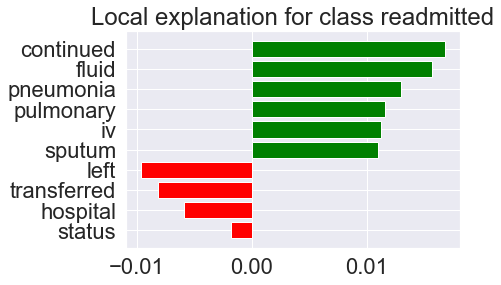

In [58]:
%matplotlib inline
# plt.figure(figsize=(20, 12))
fig = exp.as_pyplot_figure()